In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessor import Preprocessor
from pdf_reader import PDFReader
from vectorizer import Vectorizer
from tqdm import tqdm
from sklearn.cluster import KMeans

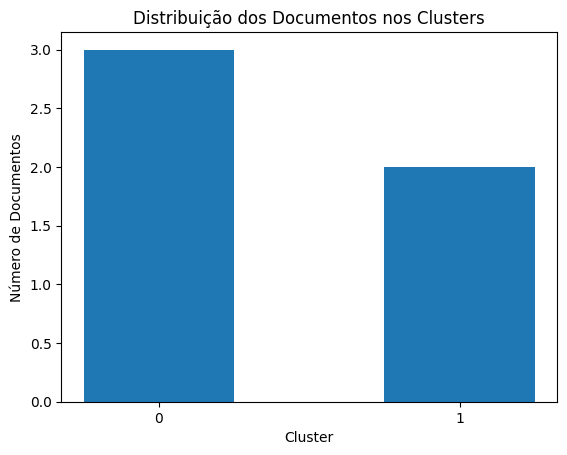

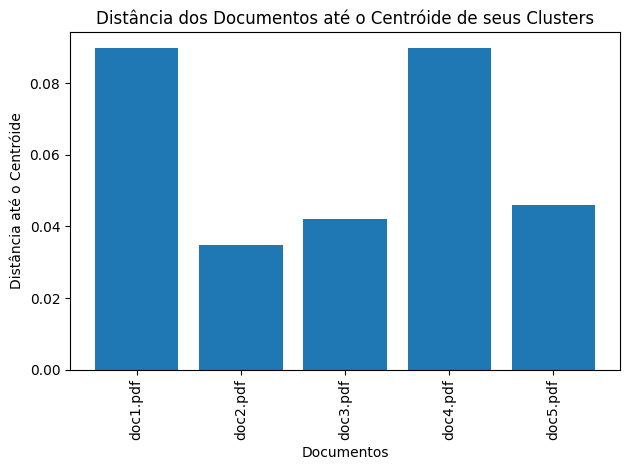

In [10]:
def extract_and_preprocess(file_paths, pdf_reader, preprocessor):
    processed_files = []
    for file in tqdm(file_paths, desc="Processing files", leave=True, bar_format='{l_bar}{bar}|'):
        processed_file = preprocessor.process(pdf_reader.extract_text(file))
        processed_files.append(processed_file)
    return processed_files

# Initialize classes
preprocessor = Preprocessor()
pdf_reader = PDFReader()
vectorizer = Vectorizer("cbow_s1000.txt")

# Paths to the documents
doc_paths = ["doc1.pdf", "doc2.pdf", "doc3.pdf", "doc4.pdf", "doc5.pdf"]

# Extract and preprocess the template documents
doc_vectors = [vectorizer.calculate_document_vector(preprocessor.process(pdf_reader.extract_text(path))) for path in doc_paths]

# Run KMeans
k = 2
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(doc_vectors)
labels = kmeans.labels_

# Visualizing the cluster distribution
plt.hist(labels, bins=np.arange(0, k+1) - 0.5, rwidth=0.5, align='mid')
plt.xticks(range(k))
plt.xlabel('Cluster')
plt.ylabel('Número de Documentos')
plt.title('Distribuição dos Documentos nos Clusters')
plt.show()

# Calculating the distances to the centroid
distances_to_centroid = []
for i, doc_vec in enumerate(doc_vectors):
    centroid = kmeans.cluster_centers_[labels[i]]
    distance = np.linalg.norm(doc_vec - centroid)
    distances_to_centroid.append(distance)

# Visualizing the distances to the centroid
plt.bar(range(len(doc_paths)), distances_to_centroid)
plt.xlabel('Documentos')
plt.xticks(range(len(doc_paths)), doc_paths, rotation=90)
plt.ylabel('Distância até o Centróide')
plt.title('Distância dos Documentos até o Centróide de seus Clusters')
plt.tight_layout()
plt.show()